# NetColoc analysis of rare variants in Autism spectrum disorder (ASD). 

Example of NetColoc workflow on genes associated with rare exome variants in ASD only, to demonstrate workflow from single gene set





# _Obtain input gene sets and interactome_

## 1. Load required packages

In [1]:
# load required packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import re
import random

from IPython.display import display

import getpass
import ndex2

import json
import cdapsutil

from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

from scipy.stats import hypergeom
from scipy.stats import norm

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

from datetime import datetime
import sys
%matplotlib inline

DISCLAIMIER: cdapsutil is experimental and may contain errors and interfaces may change


In [2]:
# verify DDOT was installed
import ddot

from netcoloc import netprop_zscore, netprop, network_colocalization, validation


## 2. Select one gene set of interest. Load gene set from text files into python.


Identify one gene sets of interest. Gene sets should come from experimental data (not manual curation) to avoid bias. 

**Usage Note**: gene sets should be < 500 genes (propagation algorithm breaks down if seeded with larger sets). If your gene set is larger, only use the top 500 as seeds to the network propagation.



In [4]:
# set names of geneset 1
# ------ customize this section based on your gene sets and how they should be labeled -------
d1_name='ASD'


In [5]:
# ------ customize this section based your input genesets -------

# load rare variants Satterstrom et al 2020; PMID: 31981491
D1_df = pd.read_csv('data/Satterstrom--Top-102-ASD-genes--May2019.csv')
D1_df.index = D1_df['gene']
print('Number of '+d1_name+' genes:', len(D1_df))
D1_genes = D1_df.index.tolist() # define rare variant genes to seed network propagation
print("First 5 genes:", D1_genes[0:5])

Number of ASD genes: 102
First 5 genes: ['CHD8', 'SCN2A', 'SYNGAP1', 'ADNP', 'FOXP1']


## 3. Select gene interaction network to use for the analysis.

Identify network UUID on NDEx (ndexbio.org) and use this to import to this Jupyter notebook. We recommend using PCNet as a starting point, but a user may want to switch to “STRING high confidence” if using a machine with low memory (< 8GB RAM).


In [6]:
# interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
interactome_uuid='275bd84e-3d18-11e8-a935-0ac135e8bacf' # for STRING high confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# remove self edges from network
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out the numbers of nodes and edges in the interatome for diagnostic purposes:
print('Number of nodes:', len(G_int.nodes))
print('\nNumber of edges:', len(G_int.edges))

Number of nodes: 17185

Number of edges: 420534


In [7]:
int_nodes = list(G_int.nodes)

# _Identify network colocalized gene network_

## 4. Precalculate matrices needed for propagation. This step should take a few minutes (more for larger/denser networks) 

A benchmarking analysis demonstrates that the runtime required scales with the number of edges (w’) and the number of nodes (w’’). NetColoc includes functionality for saving and loading these matrices, by setting the XXX parameter, which can be useful if running multiple analyses. The diffusion parameter, which controls the rate of propagation through the network, may be set in this step. In practice, we have found that results are not dependent on the choice of this parameter, and recommend using the default value of 0.5.

Background on network propagation: https://www.nature.com/articles/nrg.2017.38.pdf?origin=ppub


In [8]:
# pre-calculate matrices used for network propagation. this step takes a few minutes, more for denser interactomes
print('\ncalculating w_prime')
w_prime = netprop.get_normalized_adjacency_matrix(G_int, conserve_heat=True)

print('\ncalculating w_double_prime')
w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)

# w_double_prime can be saved to the file netcoloc_w_double_prime.npy
# in current working directory with the following call:
#
# np.save('netcoloc_w_double_prime.npy', w_double_prime)

# and reloaded later with:
# w_double_prime = np.load('netcoloc_w_double_prime.npy')
#
# NOTE: Saving w_double_prime results in a several gigabyte file and
#       takes a minute or more to save and load



calculating w_prime

calculating w_double_prime


## 5. Subset seed genes to those found in the selected network. 

Only genes contained in the interaction network will be retained for downstream analysis. 


In [9]:
# subset seed genes to those found in interactome
print("Number of D1 genes:", len(D1_genes))
D1_genes = list(np.intersect1d(D1_genes,int_nodes))
print("Number of D1 genes in interactome:", len(D1_genes))




Number of D1 genes: 102
Number of D1 genes in interactome: 98


## 6. Compute network proximity scores from seed gene set.

The network proximity scores include a correction for the degree distribution of the input gene sets. The runtime required for computing the network proximity scores increases linearly with the number of nodes in the underlying interaction network and with the size of the input gene list

In [10]:
# D1 network propagation
print('\nCalculating D1 z-scores: ')
z_D1, Fnew_D1, Fnew_rand_D1 = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                                                    dict(G_int.degree), 
                                                                    D1_genes, num_reps=1000,
                                                                    minimum_bin_size=100)

z_D1 = pd.DataFrame({'z':z_D1})

z_D1.sort_values('z',ascending=False).head()


Calculating D1 z-scores: 


,z
KDM6B,10.991122
ASXL3,10.905475
TRAF7,10.895410
KMT2E,10.783263
DIP2A,10.639522


## 7. Build proximal subnetwork by taking z> thresh 

Select genes which have z>threshold (default = 3). These genes are proximal in network space to the seed gene set

In [15]:
# ----------- select thresholds for NetColoc -----------------
zthresh=3 # default = 3

# select the genes in the network intersection, make a subgraph

G_prox = nx.subgraph(G_int,z_D1[z_D1['z']>zthresh].index.tolist()) 
print("Nodes in proximal subgraph:", len(G_prox.nodes()))
print("Edges in proximal subgraph:", len(G_prox.edges()))

Nodes in proximal subgraph: 416
Edges in proximal subgraph: 1478


## 8. Transform NetColoc proximal subnetwork edges to cosine similarities (OPTIONAL)

Transform NetColoc subnetwork edges to cosine similarities, with the function ‘network_colocalization.transform_edges’. The cosine similarity score between two genes represents the extent to which those genes have similar interactors. In practice, the cosine similarity transformed score helps to visually reveal the underlying clustering structure present in a network. 



In [16]:
G_cosSim=network_colocalization.transform_edges(G_prox,method='cosine_sim',edge_weight_threshold=0.95)

# _Compute systems map from proximal subgraph_

## 9. Convert network colocalization subnetwork to form used in community detection module

In [19]:
# compile dataframe of metadata for overlapping nodes
node_df = pd.DataFrame(index=list(G_prox.nodes))
node_df = node_df.assign(d1_seeds=0, d1_name=d1_name,)
node_df.loc[list(np.intersect1d(D1_genes,node_df.index.tolist())), 'd1_seeds']=1
node_df['z_d1']=z_D1.loc[list(G_prox.nodes)]['z']
node_df['sum_seeds']=node_df['d1_seeds']

node_df = node_df.sort_values('z_d1',ascending=False)
node_df.head(15)

,d1_seeds,d1_name,z_d1,sum_seeds
KDM6B,1,ASD,10.991122,1
ASXL3,1,ASD,10.905475,1
TRAF7,1,ASD,10.895410,1
KMT2E,1,ASD,10.783263,1
DIP2A,1,ASD,10.639522,1
NACC1,1,ASD,10.193232,1
PHF2,1,ASD,10.084412,1
ANKRD11,1,ASD,9.418459,1
DSCAM,1,ASD,9.185663,1
MBD5,1,ASD,9.112523,1


## 10. Run community detection on NetColoc subnetwork (recommend HiDef).

Documentation for CDAPS utils to build multiscale systems map in notebook

https://cdapsutil.readthedocs.io/en/latest/quicktutorial.html#example  
https://cdapsutil.readthedocs.io/en/latest/cdapsutil.html#community-detection  

In [21]:
print("Nodes in overlap subgraph:", len(G_prox.nodes()))
print("Edges in overlap subgraph:", len(G_prox.edges()))
# Create cx format of overlap subgraph
G_prox_cx = ndex2.create_nice_cx_from_networkx(G_prox)
G_prox_cx.set_name(d1_name+'_NetColoc_subgraph') 
for node_id, node in G_prox_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_prox_cx.set_node_attribute(node_id, row, value, type=data_type)

cd = cdapsutil.CommunityDetection()

# Run HiDeF on CDAPS REST service
G_hier = cd.run_community_detection(G_prox_cx, algorithm='hidefv1.1beta',arguments={'--maxres':'20'})

Nodes in overlap subgraph: 416
Edges in overlap subgraph: 1478


In [22]:
# Print information about hierarchy
print('Hierarchy name: ' + str(G_hier.get_name()))
print('# nodes: ' + str(len(G_hier.get_nodes())))
print('# edges: ' + str(len(G_hier.get_edges())))

Hierarchy name: hidefv1.1beta_(none)_ASD_NetColoc_subgraph
# nodes: 114
# edges: 142


In [23]:
# sr = cdapsutil.ServiceRunner()
# sr.get_algorithms() # this will print out available options for each algorithm

## 11. Convert the NetColoc hierarchy to networkx format, and write out features of the hierarchy to a pandas dataframe, for easier access in Python.


In [24]:
G_hier = G_hier.to_networkx(mode='default')
G_hier

nodes = G_hier.nodes()

# print the number of nodes and edges in the hierarchy for diagnostic purposes
print('Number of nodes:', len(G_hier.nodes()))

print('\nNumber of edges:', len(G_hier.edges()))


Number of nodes: 114

Number of edges: 142


In [25]:
# add node attributes to dataframe for easier access
hier_df = pd.DataFrame.from_dict(dict(G_hier.nodes(data=True)), orient='index')
hier_df['system_ID']=hier_df.index.tolist()
# some columns are not the right type
hier_df['CD_MemberList_Size']=[int(x) for x in hier_df['CD_MemberList_Size'].tolist()]
hier_df['HiDeF_persistence']=[int(x) for x in hier_df['HiDeF_persistence'].tolist()]
hier_df.head()

,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,system_ID
0,CCKBR LGALS4 C3orf30 KATNAL2 RORA PAX9 LHX3 WH...,411,False,8.683,,,0,0.0,0.0,65,C416,C416,0
1,ANKRD11 CD6 SLC15A3 ALCAM,4,False,2.0,,,0,0.0,0.0,237,C514,C514,1
2,PPP5D1 PSPC1 PPP5C TATDN1,4,False,2.0,,,0,0.0,0.0,54,C515,C515,2
3,C11orf30 PHF12 BRMS1L AIDA,4,False,2.0,,,0,0.0,0.0,7,C525,C525,3
4,CHD6 SETD2 HIST1H2BM SETD1B NR2F2 BRMS1L SUV42...,157,False,7.295,,,0,0.0,0.0,65,C417,C417,4


## 12. Remove systems with no seed genes (OPTIONAL)

In [28]:
hier_df.index=hier_df['name']
hier_df.head()

num_d1_seeds = []
frac_d1_seeds=[]

systems_keep = []
for c in hier_df.index.tolist():
    system_genes = hier_df['CD_MemberList'].loc[c].split(' ')
    d1_temp = list(np.intersect1d(system_genes,D1_genes))

    num_d1_temp = len(d1_temp)
    if (num_d1_temp)>0: # keep the system if it has at least 1 seed gene
        systems_keep.append(c)
        num_d1_seeds.append(num_d1_temp)
        
        frac_d1_seeds.append((num_d1_temp)/float(len(system_genes)))

        
frac_no_seeds = np.subtract(1.0,np.array([frac_d1_seeds]).sum(axis=0))

hier_df = hier_df.loc[systems_keep]
hier_df['num_d1_seeds']=num_d1_seeds
hier_df['frac_d1_seeds']=frac_d1_seeds
hier_df['frac_no_seeds']=frac_no_seeds
print("Number of nodes with seed genes:", len(hier_df))

hier_df.head()
    

Number of nodes with seed genes: 111


,CD_MemberList,CD_MemberList_Size,CD_Labeled,CD_MemberList_LogSize,CD_CommunityName,CD_AnnotatedMembers,CD_AnnotatedMembers_Size,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,HiDeF_persistence,represents,name,system_ID,num_d1_seeds,frac_d1_seeds,frac_no_seeds
name,,,,,,,,,,,,,,,,
C416,CCKBR LGALS4 C3orf30 KATNAL2 RORA PAX9 LHX3 WH...,411,False,8.683,,,0,0.0,0.0,65,C416,C416,0,94,0.228710,0.771290
C514,ANKRD11 CD6 SLC15A3 ALCAM,4,False,2.0,,,0,0.0,0.0,237,C514,C514,1,1,0.250000,0.750000
C515,PPP5D1 PSPC1 PPP5C TATDN1,4,False,2.0,,,0,0.0,0.0,54,C515,C515,2,1,0.250000,0.750000
C525,C11orf30 PHF12 BRMS1L AIDA,4,False,2.0,,,0,0.0,0.0,7,C525,C525,3,1,0.250000,0.750000
C417,CHD6 SETD2 HIST1H2BM SETD1B NR2F2 BRMS1L SUV42...,157,False,7.295,,,0,0.0,0.0,65,C417,C417,4,34,0.216561,0.783439


In [29]:
# prune G_hier--> only keep systems with at least one seed gene

nkeep=[]
for n in list(G_hier.nodes()):
    if G_hier.nodes(data=True)[n]['name'] in systems_keep:
        nkeep.append(n)
        

G_hier = nx.subgraph(G_hier, nkeep)
print("Number of nodes with seed genes:", len(G_hier.nodes()))
print("Number of edges remaining:", len(G_hier.edges()))

Number of nodes with seed genes: 111
Number of edges remaining: 137


## 13. Sneak peek of hierarchy visualization (OPTIONAL)

In [30]:
network_colocalization.view_G_hier(G_hier)

CytoscapeWidget(cytoscape_layout={'name': 'cose'}, cytoscape_style=[{'selector': 'node', 'css': {'content': 'd…

## 14. Annotate systems with gprofiler. 

Annotate moderately sized systems (between 50 to 1000 genes per system) if they are significantly enriched for a Gene Ontology biological process. Also require that the GO term is enriched with $p<10^{-5}$ and shares at least 3 genes with the system to annotate, to increase the stringency of the annotation. Label the system using the GO term that meets these criteria, and has the highest sum of precision and recall. Systems which have no GO terms meeting these criteria are labeled with their unique system ID.


In [31]:
# gprofiler annotation of clusters

system_name_list = []
for p in hier_df.index.tolist():
    focal_genes=hier_df['CD_MemberList'].loc[p].split(' ')
    print(p)
    print(len(focal_genes))
    if len(focal_genes)>2:
        gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                               sources=['REAC']))
        if len(gp_temp)>0: # make sure data is not empty
            
            # make sure terms are specific, and overlap with at least 3 genes
            gp_temp = gp_temp[(gp_temp['term_size']<1000)&(gp_temp['term_size']>50)]
            gp_temp = gp_temp[gp_temp['intersection_size']>=3]
            
            gp_temp = gp_temp[gp_temp['p_value']<1E-5] # set a stringent pvalue threshold
            
            gp_temp = gp_temp.sort_values('recall',ascending=False)
            
            if len(gp_temp)>1:
                system_name_list.append(gp_temp.head(1)['name'].tolist()[0])
            else:
                system_name_list.append(p)
        else:
            system_name_list.append(p)
            

        display(gp_temp.head())
        
    else:
        system_name_list.append(p)

C416
411


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
3,PKMTs methylate histone lysines,10770,17,PKMTs methylate histone lysines,REAC:R-HSA-3214841,1.555968e-12,[REAC:R-HSA-3247509],0.085,query_1,200,0.239437,True,REAC,71
4,RUNX1 regulates genes involved in megakaryocyt...,10770,18,RUNX1 regulates genes involved in megakaryocyt...,REAC:R-HSA-8936459,2.294696e-11,[REAC:R-HSA-8878171],0.090,query_1,200,0.185567,True,REAC,97
11,Transcriptional Regulation by MECP2,10770,10,Transcriptional Regulation by MECP2,REAC:R-HSA-8986944,6.585345e-06,[REAC:R-HSA-212436],0.050,query_1,200,0.169492,True,REAC,59
0,Chromatin modifying enzymes,10770,43,Chromatin modifying enzymes,REAC:R-HSA-3247509,1.171505e-25,[REAC:R-HSA-4839726],0.215,query_1,200,0.157509,True,REAC,273
1,Chromatin organization,10770,43,Chromatin organization,REAC:R-HSA-4839726,1.171505e-25,[REAC:0000000],0.215,query_1,200,0.157509,True,REAC,273


C514
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C515
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C525
4


""


C417
157


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
2,PKMTs methylate histone lysines,10770,17,PKMTs methylate histone lysines,REAC:R-HSA-3214841,1.518226e-18,[REAC:R-HSA-3247509],0.184783,query_1,92,0.239437,True,REAC,71
3,RUNX1 regulates genes involved in megakaryocyt...,10770,18,RUNX1 regulates genes involved in megakaryocyt...,REAC:R-HSA-8936459,1.096578e-17,[REAC:R-HSA-8878171],0.195652,query_1,92,0.185567,True,REAC,97
0,Chromatin organization,10770,40,Chromatin organization,REAC:R-HSA-4839726,1.035896e-37,[REAC:0000000],0.434783,query_1,92,0.146520,True,REAC,273
1,Chromatin modifying enzymes,10770,40,Chromatin modifying enzymes,REAC:R-HSA-3247509,1.035896e-37,[REAC:R-HSA-4839726],0.434783,query_1,92,0.146520,True,REAC,273
9,Formation of the beta-catenin:TCF transactivat...,10770,12,Formation of the beta-catenin:TCF transactivat...,REAC:R-HSA-201722,5.739398e-10,[REAC:R-HSA-201681],0.130435,query_1,92,0.131868,True,REAC,91


C418
106


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
2,L1CAM interactions,10770,8,L1CAM interactions,REAC:R-HSA-373760,0.000006,[REAC:R-HSA-422475],0.156863,query_1,51,0.067227,True,REAC,119
1,Neuronal System,10770,13,Neuronal System,REAC:R-HSA-112316,0.000003,[REAC:0000000],0.254902,query_1,51,0.032500,True,REAC,400


C420
67


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C421
56


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C423
49


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C426
36


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C433
21


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Circadian Clock,10770,7,Circadian Clock,REAC:R-HSA-400253,2.409112e-10,[REAC:0000000],0.466667,query_1,15,0.104478,True,REAC,67
6,Transcriptional regulation of white adipocyte ...,10770,5,Transcriptional regulation of white adipocyte ...,REAC:R-HSA-381340,1.361838e-06,[REAC:R-HSA-1266738],0.333333,query_1,15,0.060976,True,REAC,82
3,PPARA activates gene expression,10770,6,PPARA activates gene expression,REAC:R-HSA-1989781,1.700310e-07,[REAC:R-HSA-400206],0.400000,query_1,15,0.053097,True,REAC,113
2,Regulation of lipid metabolism by PPARalpha,10770,6,Regulation of lipid metabolism by PPARalpha,REAC:R-HSA-400206,1.700310e-07,[REAC:R-HSA-556833],0.400000,query_1,15,0.052632,True,REAC,114


C460
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C471
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C472
8


""


C474
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C480
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C481
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C490
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C491
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C502
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C419
84


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
2,RUNX1 regulates genes involved in megakaryocyt...,10770,18,RUNX1 regulates genes involved in megakaryocyt...,REAC:R-HSA-8936459,1.582238e-22,[REAC:R-HSA-8878171],0.339623,query_1,53,0.185567,True,REAC,97
9,PKMTs methylate histone lysines,10770,11,PKMTs methylate histone lysines,REAC:R-HSA-3214841,9.128375e-13,[REAC:R-HSA-3247509],0.207547,query_1,53,0.154930,True,REAC,71
8,Formation of the beta-catenin:TCF transactivat...,10770,12,Formation of the beta-catenin:TCF transactivat...,REAC:R-HSA-201722,4.577812e-13,[REAC:R-HSA-201681],0.226415,query_1,53,0.131868,True,REAC,91
12,HDACs deacetylate histones,10770,11,HDACs deacetylate histones,REAC:R-HSA-3214815,1.742895e-11,[REAC:R-HSA-3247509],0.207547,query_1,53,0.117021,True,REAC,94
1,Chromatin modifying enzymes,10770,29,Chromatin modifying enzymes,REAC:R-HSA-3247509,8.606647e-31,[REAC:R-HSA-4839726],0.547170,query_1,53,0.106227,True,REAC,273


C451
12


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Transcriptional regulation of white adipocyte ...,10770,5,Transcriptional regulation of white adipocyte ...,REAC:R-HSA-381340,1.567492e-07,[REAC:R-HSA-1266738],0.625,query_1,8,0.060976,True,REAC,82


C521
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C427
31


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Potential therapeutics for SARS,10770,7,Potential therapeutics for SARS,REAC:R-HSA-9679191,8.384305e-09,[REAC:R-HSA-9679506],0.368421,query_1,19,0.088608,True,REAC,79
4,Regulation of PTEN gene transcription,10770,5,Regulation of PTEN gene transcription,REAC:R-HSA-8943724,1.865763e-06,[REAC:R-HSA-6807070],0.263158,query_1,19,0.084746,True,REAC,59
1,HDACs deacetylate histones,10770,7,HDACs deacetylate histones,REAC:R-HSA-3214815,1.458674e-08,[REAC:R-HSA-3247509],0.368421,query_1,19,0.074468,True,REAC,94
7,ERCC6 (CSB) and EHMT2 (G9a) positively regulat...,10770,5,ERCC6 (CSB) and EHMT2 (G9a) positively regulat...,REAC:R-HSA-427389,4.719218e-06,[REAC:R-HSA-5250913],0.263158,query_1,19,0.065789,True,REAC,76
2,SARS-CoV Infections,10770,7,SARS-CoV Infections,REAC:R-HSA-9679506,2.407319e-07,[REAC:R-HSA-5663205],0.368421,query_1,19,0.047297,True,REAC,148


C461
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,UCH proteinases,10770,8,UCH proteinases,REAC:R-HSA-5689603,7.221057e-16,[REAC:R-HSA-5688426],1.0,query_1,8,0.079208,True,REAC,101
1,Deubiquitination,10770,8,Deubiquitination,REAC:R-HSA-5688426,2.506519e-12,[REAC:R-HSA-597592],1.0,query_1,8,0.026846,True,REAC,298


C431
27


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
2,PKMTs methylate histone lysines,10770,8,PKMTs methylate histone lysines,REAC:R-HSA-3214841,2.979062e-14,[REAC:R-HSA-3247509],0.615385,query_1,13,0.112676,True,REAC,71
0,Chromatin modifying enzymes,10770,12,Chromatin modifying enzymes,REAC:R-HSA-3247509,1.056145e-17,[REAC:R-HSA-4839726],0.923077,query_1,13,0.043956,True,REAC,273
1,Chromatin organization,10770,12,Chromatin organization,REAC:R-HSA-4839726,1.056145e-17,[REAC:0000000],0.923077,query_1,13,0.043956,True,REAC,273


C440
16


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
3,Formation of the beta-catenin:TCF transactivat...,10770,5,Formation of the beta-catenin:TCF transactivat...,REAC:R-HSA-201722,1.620649e-07,[REAC:R-HSA-201681],0.5,query_1,10,0.054945,True,REAC,91
1,TCF dependent signaling in response to WNT,10770,7,TCF dependent signaling in response to WNT,REAC:R-HSA-201681,7.709429e-09,[REAC:R-HSA-195721],0.7,query_1,10,0.030172,True,REAC,232
2,Signaling by WNT,10770,7,Signaling by WNT,REAC:R-HSA-195721,5.820122e-08,[REAC:R-HSA-162582],0.7,query_1,10,0.021341,True,REAC,328


C505
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C477
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Transcriptional regulation of white adipocyte ...,10770,4,Transcriptional regulation of white adipocyte ...,REAC:R-HSA-381340,0.000005,[REAC:R-HSA-1266738],0.666667,query_1,6,0.04878,True,REAC,82


C447
15


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C424
46


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C436
18


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C422
53


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,L1CAM interactions,10770,8,L1CAM interactions,REAC:R-HSA-373760,1.201780e-07,[REAC:R-HSA-422475],0.258065,query_1,31,0.067227,True,REAC,119


C484
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C524
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C435
19


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,RUNX1 regulates genes involved in megakaryocyt...,10770,9,RUNX1 regulates genes involved in megakaryocyt...,REAC:R-HSA-8936459,7.580918e-15,[REAC:R-HSA-8878171],0.750000,query_1,12,0.092784,True,REAC,97
7,PKMTs methylate histone lysines,10770,5,PKMTs methylate histone lysines,REAC:R-HSA-3214841,1.360675e-07,[REAC:R-HSA-3247509],0.416667,query_1,12,0.070423,True,REAC,71
1,Transcriptional regulation by RUNX1,10770,10,Transcriptional regulation by RUNX1,REAC:R-HSA-8878171,8.854760e-14,[REAC:R-HSA-212436],0.833333,query_1,12,0.042373,True,REAC,236
5,Chromatin modifying enzymes,10770,7,Chromatin modifying enzymes,REAC:R-HSA-3247509,8.347448e-08,[REAC:R-HSA-4839726],0.583333,query_1,12,0.025641,True,REAC,273
6,Chromatin organization,10770,7,Chromatin organization,REAC:R-HSA-4839726,8.347448e-08,[REAC:0000000],0.583333,query_1,12,0.025641,True,REAC,273


C500
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C499
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C511
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,TCF dependent signaling in response to WNT,10770,4,TCF dependent signaling in response to WNT,REAC:R-HSA-201681,0.000006,[REAC:R-HSA-195721],1.0,query_1,4,0.017241,True,REAC,232


C443
16


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C446
15


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C425
40


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C482
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,Circadian Clock,10770,4,Circadian Clock,REAC:R-HSA-400253,1.838176e-07,[REAC:0000000],0.8,query_1,5,0.059701,True,REAC,67


C441
16


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C450
12


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C432
22


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C468
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C437
18


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,L1CAM interactions,10770,8,L1CAM interactions,REAC:R-HSA-373760,3.732452e-11,[REAC:R-HSA-422475],0.571429,query_1,14,0.067227,True,REAC,119
2,COPI-mediated anterograde transport,10770,6,COPI-mediated anterograde transport,REAC:R-HSA-6807878,8.784889e-08,[REAC:R-HSA-199977],0.428571,query_1,14,0.058824,True,REAC,102
3,ER to Golgi Anterograde Transport,10770,6,ER to Golgi Anterograde Transport,REAC:R-HSA-199977,8.258636e-07,"[REAC:R-HSA-199991, REAC:R-HSA-948021]",0.428571,query_1,14,0.038710,True,REAC,155
4,Transport to the Golgi and subsequent modifica...,10770,6,Transport to the Golgi and subsequent modifica...,REAC:R-HSA-948021,1.965941e-06,[REAC:R-HSA-446203],0.428571,query_1,14,0.032258,True,REAC,186
5,Axon guidance,10770,8,Axon guidance,REAC:R-HSA-422475,2.478926e-06,[REAC:R-HSA-9675108],0.571429,query_1,14,0.014572,True,REAC,549


C473
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C507
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C430
27


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C439
17


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C483
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C429
27


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C462
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,G alpha (q) signalling events,10770,4,G alpha (q) signalling events,REAC:R-HSA-416476,0.000001,[REAC:R-HSA-388396],1.0,query_1,4,0.018868,True,REAC,212
1,Class A/1 (Rhodopsin-like receptors),10770,4,Class A/1 (Rhodopsin-like receptors),REAC:R-HSA-373076,0.000004,[REAC:R-HSA-500792],1.0,query_1,4,0.012195,True,REAC,328


C449
13


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C458
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C459
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C428
29


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C510
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C479
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C529
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,SUMO E3 ligases SUMOylate target proteins,10770,4,SUMO E3 ligases SUMOylate target proteins,REAC:R-HSA-3108232,0.000004,[REAC:R-HSA-2990846],1.0,query_1,4,0.023529,True,REAC,170
1,SUMOylation,10770,4,SUMOylation,REAC:R-HSA-2990846,0.000004,[REAC:R-HSA-597592],1.0,query_1,4,0.022727,True,REAC,176


C494
6


""


C495
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C506
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C434
19


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C467
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C438
18


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C464
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C445
15


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C452
12


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C503
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C442
16


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,PKMTs methylate histone lysines,10770,5,PKMTs methylate histone lysines,REAC:R-HSA-3214841,4.316920e-11,[REAC:R-HSA-3247509],1.0,query_1,5,0.070423,True,REAC,71
1,Chromatin modifying enzymes,10770,5,Chromatin modifying enzymes,REAC:R-HSA-3247509,1.346110e-08,[REAC:R-HSA-4839726],1.0,query_1,5,0.018315,True,REAC,273
2,Chromatin organization,10770,5,Chromatin organization,REAC:R-HSA-4839726,1.346110e-08,[REAC:0000000],1.0,query_1,5,0.018315,True,REAC,273


C476
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C455
11


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,PKMTs methylate histone lysines,10770,5,PKMTs methylate histone lysines,REAC:R-HSA-3214841,7.730755e-10,[REAC:R-HSA-3247509],0.833333,query_1,6,0.070423,True,REAC,71
1,Chromatin modifying enzymes,10770,6,Chromatin modifying enzymes,REAC:R-HSA-3247509,1.005362e-09,[REAC:R-HSA-4839726],1.000000,query_1,6,0.021978,True,REAC,273
2,Chromatin organization,10770,6,Chromatin organization,REAC:R-HSA-4839726,1.005362e-09,[REAC:0000000],1.000000,query_1,6,0.021978,True,REAC,273


C488
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C444
15


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C448
13


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C492
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C475
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C485
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,PKMTs methylate histone lysines,10770,5,PKMTs methylate histone lysines,REAC:R-HSA-3214841,2.374306e-10,[REAC:R-HSA-3247509],1.0,query_1,5,0.070423,True,REAC,71
1,RUNX1 regulates genes involved in megakaryocyt...,10770,5,RUNX1 regulates genes involved in megakaryocyt...,REAC:R-HSA-8936459,5.876177e-10,[REAC:R-HSA-8878171],1.0,query_1,5,0.051546,True,REAC,97
2,Transcriptional regulation by RUNX1,10770,5,Transcriptional regulation by RUNX1,REAC:R-HSA-8878171,3.553578e-08,[REAC:R-HSA-212436],1.0,query_1,5,0.021186,True,REAC,236
3,Chromatin modifying enzymes,10770,5,Chromatin modifying enzymes,REAC:R-HSA-3247509,4.442162e-08,[REAC:R-HSA-4839726],1.0,query_1,5,0.018315,True,REAC,273
4,Chromatin organization,10770,5,Chromatin organization,REAC:R-HSA-4839726,4.442162e-08,[REAC:0000000],1.0,query_1,5,0.018315,True,REAC,273


C496
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C512
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C469
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
1,L1CAM interactions,10770,7,L1CAM interactions,REAC:R-HSA-373760,8.923599e-12,[REAC:R-HSA-422475],0.777778,query_1,9,0.058824,True,REAC,119
2,COPI-mediated anterograde transport,10770,5,COPI-mediated anterograde transport,REAC:R-HSA-6807878,8.440872e-08,[REAC:R-HSA-199977],0.555556,query_1,9,0.049020,True,REAC,102
5,ER to Golgi Anterograde Transport,10770,5,ER to Golgi Anterograde Transport,REAC:R-HSA-199977,3.481352e-07,"[REAC:R-HSA-199991, REAC:R-HSA-948021]",0.555556,query_1,9,0.032258,True,REAC,155
6,Transport to the Golgi and subsequent modifica...,10770,5,Transport to the Golgi and subsequent modifica...,REAC:R-HSA-948021,7.434352e-07,[REAC:R-HSA-446203],0.555556,query_1,9,0.026882,True,REAC,186
7,Asparagine N-linked glycosylation,10770,5,Asparagine N-linked glycosylation,REAC:R-HSA-446203,7.588123e-06,[REAC:R-HSA-597592],0.555556,query_1,9,0.016393,True,REAC,305


C508
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C457
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C486
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C453
11


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C493
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C463
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C465
9


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,PKMTs methylate histone lysines,10770,3,PKMTs methylate histone lysines,REAC:R-HSA-3214841,0.000001,[REAC:R-HSA-3247509],1.0,query_1,3,0.042254,True,REAC,71


C509
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C456
10


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C501
6


""


C454
11


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C497
6


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,SLC-mediated transmembrane transport,10770,5,SLC-mediated transmembrane transport,REAC:R-HSA-425407,1.493398e-07,[REAC:R-HSA-382551],1.0,query_1,5,0.020161,True,REAC,248
1,Transport of small molecules,10770,5,Transport of small molecules,REAC:R-HSA-382551,7.908499e-06,[REAC:0000000],1.0,query_1,5,0.006944,True,REAC,720


C466
9


""


C470
9


""


C498
6


""


C487
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C478
8


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C489
7


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C516
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C522
4


""


C518
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C519
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C513
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C504
5


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


C517
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size
0,PKMTs methylate histone lysines,10770,3,PKMTs methylate histone lysines,REAC:R-HSA-3214841,0.000005,[REAC:R-HSA-3247509],1.0,query_1,3,0.042254,True,REAC,71
1,RUNX1 regulates genes involved in megakaryocyt...,10770,3,RUNX1 regulates genes involved in megakaryocyt...,REAC:R-HSA-8936459,0.000007,[REAC:R-HSA-8878171],1.0,query_1,3,0.030928,True,REAC,97


C527
4


""


C526
4


,description,effective_domain_size,intersection_size,name,native,p_value,parents,precision,query,query_size,recall,significant,source,term_size


# _Validate identified genes and systems_

## 15. Load and parse mouse variant database

Requires DDOT for ontology parsing https://github.com/michaelkyu/ddot/blob/master/examples/Tutorial.ipynb

Parse the ontology, data from http://www.informatics.jax.org/vocab/mp_ontology


In [32]:
mgi_df = validation.load_MGI_mouseKO_data()
mgi_df.head()

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-24543...done.
Finished.
20 input query terms found dup hits:
	[('Adam1a', 2), ('Chaserr', 2), ('Dnm3os', 2), ('Eldr', 2), ('Glra4', 2), ('Hottip', 2), ('Ighd', 2)
12398 input query terms found no hit:
	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(11Stat5a-Stat5b)1Mam'
Pass "re

,MGI_Allele_Accession_ID,Allele symbol,involves,MP,PMID,MGI_marker_accession_ID,gene_name,human_ortholog
gene_name,,,,,,,,
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000600,12529408,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001716,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001698,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0001092,16449662,MGI:97874,Rb1,RB1
Rb1,Rb1<tm1Tyj>/Rb1<tm1Tyj>,Rb1<tm1Tyj>,involves: 129S2/SvPas,MP:0000961,16449662,MGI:97874,Rb1,RB1


In [33]:
MPO = validation.load_MPO()
MPO

14810


,description
MP,
MP:0000001,mammalian phenotype
MP:0000002,obsolete Morphology
MP:0000003,abnormal adipose tissue morphology
MP:0000011,abnormal adipose tissue morphology
MP:0000005,increased brown adipose tissue amount


,Parent,Child,Relation,Namespace
0,MP:0005375,MP:0000003,is_a,MPheno.ontology
1,MP:0001778,MP:0000005,is_a,MPheno.ontology
2,MP:0001781,MP:0000008,is_a,MPheno.ontology
3,MP:0005334,MP:0000010,is_a,MPheno.ontology
4,MP:0000003,MP:0000013,is_a,MPheno.ontology


0 genes, 13672 terms, 0 gene-term relations, 17346 term-term relations
node_attributes: ['description']
edge_attributes: ['Relation', 'Namespace']

## 16. Identify phenotype(s) of interest. 

Recommend including a negative control, a phenotype that is not expected to overlap with the two phenotypes of interest.

### Here we find MPO terms related to brain or heart

Modify as needed for each specific project

In [34]:
def get_MP_description(term_id, ontology=MPO):
    return ontology.node_attr.loc[term_id, "description"]

In [35]:
# find terms related to brain
# ---- modify this part as needed for your project -----
MP_focal_brain_list = []
for t in MPO.node_attr.index.tolist():
    descr_temp = MPO.node_attr.loc[t]['description']
    if descr_temp.find('nervous')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('neuron')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('synapt')>-1:
        MP_focal_brain_list.append(t)
        
print("Number of brain phenotypes", len(MP_focal_brain_list))
print("Example brain phenotypes:")
print("\n".join([mp+" - "+get_MP_description(mp) for mp in MP_focal_brain_list[0:10]]))


Number of brain phenotypes 200
Example brain phenotypes:
MP:0000778 - abnormal nervous system tract morphology
MP:0000811 - hippocampal neuron degeneration
MP:0000937 - abnormal motor neuron morphology
MP:0000938 - motor neuron degeneration
MP:0000939 - decreased motor neuron number
MP:0000940 - abnormal motor neuron innervation pattern
MP:0000958 - peripheral nervous system degeneration
MP:0000965 - abnormal sensory neuron morphology
MP:0000966 - decreased sensory neuron number
MP:0000968 - abnormal sensory neuron innervation pattern


## 17. Compute the enrichment of selected phenotype(s) in NetColoc subnetwork as a whole.

By computing the enrichment in the entire NetColoc subnetwork, we identify the phenotypes with the strongest association with the entire set of genes identified to be related to both input sets.

In [36]:
# add a negative control phenotype: abnormal innate immunity: MP:0002419
# negative controls are tough here because we're dealing with development, which impacts almost everything.
MP_focal_list = ['MP:0002419']+MP_focal_brain_list
root_KO_brain_df=validation.MPO_enrichment_root(hier_df,MPO,mgi_df,MP_focal_list,G_int,verbose=True)


abnormal innate immunity
number of genes in root node = 411
number of genes in focal MPO term = 606
number overlapping genes = 9
0.14110702011931123
(-1.1654239055794087, 0.1658261748879888)
-0.49979886534570994

abnormal nervous system tract morphology
number of genes in root node = 411
number of genes in focal MPO term = 215
number overlapping genes = 21
8.846118167068254e-11
(1.0651571336135097, 1.9877828028378683)
1.526469968225689

hippocampal neuron degeneration
number of genes in root node = 411
number of genes in focal MPO term = 26
number overlapping genes = 4
0.0002267526170912075
(0.942831168199129, 3.0825921426594665)
2.012711655429298

abnormal motor neuron morphology
number of genes in root node = 411
number of genes in focal MPO term = 167
number overlapping genes = 8
0.04609268201409096
(0.01265022122823889, 1.446673695374994)
0.7296619583016164

motor neuron degeneration
number of genes in root node = 411
number of genes in focal MPO term = 44
number overlapping genes


abnormal dopaminergic neuron morphology
number of genes in root node = 411
number of genes in focal MPO term = 46
number overlapping genes = 2
0.392125087479101
(-0.8002414321713913, 2.0406438013308947)
0.6202011845797517

loss of dopaminergic neurons
number of genes in root node = 411
number of genes in focal MPO term = 16
number overlapping genes = 0
0.8660990604072069
(-2.5741825333772765, 3.0587863691318202)
0.24230191787727184

abnormal GABAergic neuron morphology
number of genes in root node = 411
number of genes in focal MPO term = 29
number overlapping genes = 0
0.8045523730056512
(-3.1504938364139106, 2.4441313567852125)
-0.353181239814349

loss of GABAergic neurons
number of genes in root node = 411
number of genes in focal MPO term = 12
number overlapping genes = 0
0.7135224554861573
(-2.3004336307867996, 3.3608789384161444)
0.5302226538146724

abnormal glutaminergic neuron morphology
number of genes in root node = 411
number of genes in focal MPO term = 11
number overlappi


abnormal synaptic bouton morphology
number of genes in root node = 411
number of genes in focal MPO term = 26
number overlapping genes = 1
0.6305539129588807
(-1.5101177882408057, 2.4922394870646385)
0.4910608494119164

abnormal neuron number
number of genes in root node = 411
number of genes in focal MPO term = 523
number overlapping genes = 30
9.619697871835968e-07
(0.5733352318011014, 1.3379505586474554)
0.9556428952242784

increased neuron number
number of genes in root node = 411
number of genes in focal MPO term = 83
number overlapping genes = 9
5.561932559155366e-06
(0.9209248589615724, 2.318817928874177)
1.6198713939178746

decreased neuron number
number of genes in root node = 411
number of genes in focal MPO term = 439
number overlapping genes = 21
0.001161013639274059
(0.2955761774446567, 1.1949125176743562)
0.7452443475595065

abnormal miniature inhibitory postsynaptic currents
number of genes in root node = 411
number of genes in focal MPO term = 50
number overlapping gen

In [37]:
root_KO_brain_df.head()

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description
MP:0002419,1.411070e-01,-0.499799,-1.165424,0.165826,606,abnormal innate immunity
MP:0000778,8.846118e-11,1.526470,1.065157,1.987783,215,abnormal nervous system tract morphology
MP:0000811,2.267526e-04,2.012712,0.942831,3.082592,26,hippocampal neuron degeneration
MP:0000937,4.609268e-02,0.729662,0.012650,1.446674,167,abnormal motor neuron morphology
MP:0000938,6.711207e-02,1.098911,-0.077450,2.275272,44,motor neuron degeneration


In [38]:
# join brain and heart results together
root_KO_brain_df['MPO_term_type']='brain'
root_KO_df = root_KO_brain_df
root_KO_df.loc['MP:0002419','MPO_term_type'] = 'neg_ctrl'
root_KO_df = root_KO_df.sort_values('OR_p')
root_KO_df.head()

,OR_p,log_OR,log_OR_CI_lower,log_OR_CI_upper,num_genes_in_term,MP_description,MPO_term_type
MP:0003861,7.653100e-13,0.975982,0.709088,1.242876,1234,abnormal nervous system development,brain
MP:0021009,6.133724e-12,1.016254,0.726598,1.305910,962,abnormal synaptic physiology,brain
MP:0003635,1.748691e-11,1.001272,0.709483,1.293061,956,abnormal synaptic transmission,brain
MP:0002206,3.332023e-11,1.020312,0.718737,1.321887,866,abnormal CNS synaptic transmission,brain
MP:0000778,8.846118e-11,1.526470,1.065157,1.987783,215,abnormal nervous system tract morphology,brain


In [39]:
root_KO_df['MPO_term_type'].value_counts()

brain       106
neg_ctrl      1
Name: MPO_term_type, dtype: int64

### Plot top performing brain and heart terms + negative control term

In [40]:
# plot top performing brain and heart terms + negative control term (MP:0002419) (for terms which have at least 150 genes)

brain_terms_plot = root_KO_brain_df[root_KO_brain_df['num_genes_in_term']>150]
brain_terms_plot = brain_terms_plot.sort_values('OR_p',ascending=True).head(5).index.tolist() #+brain_terms_plot.sort_values('OR_p',ascending=True).tail(5).index.tolist()

neg_ctrl_terms_plot=['MP:0002419']

terms_plot = brain_terms_plot +neg_ctrl_terms_plot

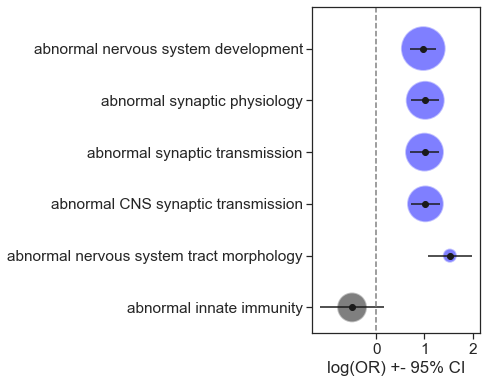

In [41]:
plt.figure(figsize=(3,6))

plt.errorbar(root_KO_df.loc[terms_plot]['log_OR'],np.arange(len(terms_plot)),
            xerr=[np.subtract(root_KO_df.loc[terms_plot]['log_OR'],root_KO_df.loc[terms_plot]['log_OR_CI_lower']),
                   np.subtract(root_KO_df.loc[terms_plot]['log_OR_CI_upper'],root_KO_df.loc[terms_plot]['log_OR'])],color='k',fmt='o')

color_temp = root_KO_df.loc[terms_plot]['MPO_term_type'].map({'brain':'blue','heart':'red','neg_ctrl':'black'})

sns.scatterplot(x=root_KO_df.loc[terms_plot]['log_OR'],
                y=np.arange(len(terms_plot)),size=root_KO_df.loc[terms_plot]['num_genes_in_term'],sizes=(200, 2000),
                alpha=.5,
               hue=color_temp.tolist(),palette={'blue':'blue','red':'red','black':'black'},legend=False)

plt.yticks(np.arange(len(terms_plot)),root_KO_df.loc[terms_plot]['MP_description'])
plt.xticks([0,1,2])
plt.xlabel('log(OR) +- 95% CI')

plt.plot([0,0],[-.8,len(terms_plot)-.5],'--',color='gray')
plt.ylim([-0.8,len(terms_plot)-.5])

plt.gca().invert_yaxis()


## 18. Compute the enrichment of phenotype(s) in NetColoc subsystems.

Some phenotypes may have stronger associations with NetColoc subsystems than with the root node. In this step we calculate the enrichment of selected phenotypes in each NetColoc subsystem.


In [42]:
MP_focal_top = root_KO_df.head(10).index.tolist() # record the top 10 overall
MP_full_results_df = validation.MPO_enrichment_full(hier_df,MPO,mgi_df,MP_focal_top,G_int)
MP_full_results_df.head()

abnormal nervous system development
Genes and Terms to keep: 191
abnormal synaptic physiology
Genes and Terms to keep: 78
abnormal synaptic transmission
Genes and Terms to keep: 73
abnormal CNS synaptic transmission
Genes and Terms to keep: 46
abnormal nervous system tract morphology
Genes and Terms to keep: 62
abnormal nervous system electrophysiology
Genes and Terms to keep: 34
abnormal neuron differentiation
Genes and Terms to keep: 16
abnormal neuron morphology
Genes and Terms to keep: 267
abnormal excitatory postsynaptic currents
Genes and Terms to keep: 9
abnormal hippocampus neuron morphology
Genes and Terms to keep: 12


,abnormal nervous system development:-log(OR_p),abnormal nervous system development:log_OR,abnormal nervous system development:num_genes,abnormal nervous system development:gene_ids,abnormal synaptic physiology:-log(OR_p),abnormal synaptic physiology:log_OR,abnormal synaptic physiology:num_genes,abnormal synaptic physiology:gene_ids,abnormal synaptic transmission:-log(OR_p),abnormal synaptic transmission:log_OR,...,abnormal neuron morphology:num_genes,abnormal neuron morphology:gene_ids,abnormal excitatory postsynaptic currents:-log(OR_p),abnormal excitatory postsynaptic currents:log_OR,abnormal excitatory postsynaptic currents:num_genes,abnormal excitatory postsynaptic currents:gene_ids,abnormal hippocampus neuron morphology:-log(OR_p),abnormal hippocampus neuron morphology:log_OR,abnormal hippocampus neuron morphology:num_genes,abnormal hippocampus neuron morphology:gene_ids
C416,12.116163,0.975982,68,ADNP AR ARID1B AUTS2 BCL11A CADPS2 CHD8 COL1A1...,11.212276,1.016254,56,ANK2 ANKRD11 ARID1B BCL11A BEX2 BICD1 CACNA1E ...,10.757287,1.001272,...,72,ALCAM ANK2 ANK3 AR ARID1B AUTS2 BCL11A CADPS2 ...,8.307267,1.626520,15,BCL11A CCKBR EMX1 GABRB3 GRIA2 GRIN2B NRXN1 PT...,7.757653,1.684923,13,ANK3 CTNNB1 EMX1 FOXG1 GABRB3 GFAP GRIA2 HIVEP...
C514,-0.000000,0.000000,0,,0.870249,1.727414,1,ANKRD11,0.875077,1.734047,...,1,ALCAM,-0.000000,0.000000,0,,-0.000000,0.000000,0,
C515,-0.000000,0.000000,0,,-0.000000,0.000000,0,,-0.000000,0.000000,...,0,,-0.000000,0.000000,0,,-0.000000,0.000000,0,
C525,-0.000000,0.000000,0,,-0.000000,0.000000,0,,-0.000000,0.000000,...,0,,-0.000000,0.000000,0,,-0.000000,0.000000,0,
C417,6.171345,1.046484,28,AR ARID1B BCL11A CREBBP CTNNB1 DPY30 GATAD2A H...,1.141963,0.507190,14,ARID1B BCL11A BEX2 CREBBP CTNNB1 DBN1 HIVEP2 N...,0.858088,0.431712,...,25,AR ARID1B BCL11A CTNNB1 DBN1 DNMT3A HBP1 HIVEP...,0.286361,0.464277,2,BCL11A PTEN,1.184225,1.088204,3,CTNNB1 HIVEP2 PTEN


In [43]:
print("Top ten terms:")
print("\n".join([mp+" - "+get_MP_description(mp) for mp in MP_focal_top]))

Top ten terms:
MP:0003861 - abnormal nervous system development
MP:0021009 - abnormal synaptic physiology
MP:0003635 - abnormal synaptic transmission
MP:0002206 - abnormal CNS synaptic transmission
MP:0000778 - abnormal nervous system tract morphology
MP:0002272 - abnormal nervous system electrophysiology
MP:0009937 - abnormal neuron differentiation
MP:0002882 - abnormal neuron morphology
MP:0002910 - abnormal excitatory postsynaptic currents
MP:0009939 - abnormal hippocampus neuron morphology


## 19. Annotate the NetColoc systems map with mouse variant data, input genes, and enriched GO terms

In [44]:
# add the best gprofiler annotation
MP_full_results_df['gprofiler_name']=pd.Series(system_name_list,index=hier_df.index.tolist())
# don't annotate the root node
root_node = hier_df['CD_MemberList_Size'].sort_values(ascending=False).head(1).index.tolist()[0]
MP_full_results_df.loc[root_node, 'gprofiler_name']=d1_name+'-'+d2_name+' systems map'

# also add the frac_seeds/num_seeds data here
MP_full_results_df=MP_full_results_df.join(hier_df[['num_d1_seeds','frac_d1_seeds','frac_no_seeds']],
                                          how='left')

MP_full_results_df.head()

NameError: name 'd2_name' is not defined

## 20. Export the NetColoc systems map to NDEx, with default style. 

Default style maps the fraction of seed genes from input set 1 (red) and input set 2 (blue) to node pie charts. The fraction of genes in each system that are in neither input set, but that are implicated by the network propagation are indicated in white.

In [48]:
# Convert G_hier to nice cx network
node_id_to_node_name = nx.get_node_attributes(G_hier, 'name')
for node_id in list(G_hier.nodes):
    del G_hier.nodes[node_id]['name']

G_hier_cx = ndex2.create_nice_cx_from_networkx(G_hier)

for node_id, node in G_hier_cx.get_nodes():
    node['n'] = node_id_to_node_name[node_id]

G_hier_cx.set_name(d1_name+'_systems_map') 
for node_id, node in G_hier_cx.get_nodes():
    data = MP_full_results_df.loc[node['r']]
    for row, value in data.items():
        if (row.find('gene_ids')>-1) or (row=='gprofiler_name'):
            data_type = "string"
            value=str(value)
        else:
            data_type = "double"
            value = str(value) # nice cx can only accept strings as values...
            if value=='inf': # check if inf, set to -1 if so
                value='-1'
            
        G_hier_cx.set_node_attribute(node_id, row, value, type=data_type)

# Restore some hierarchy properties to their state before networkx conversion.
for node_id, node in G_hier_cx.get_nodes():
    for i in np.arange(len(G_hier_cx.nodeAttributes[node_id])):
        dict_temp = G_hier_cx.nodeAttributes[node_id][i]
        if dict_temp['n'] in ['CD_MemberList_Size','CD_MemberList_LogSize','HiDeF_persistence']:
            G_hier_cx.set_node_attribute(node_id, dict_temp['n'], dict_temp['v'], type='double',overwrite=True)
            
# this is required so we can easily make subgraphs from systems
G_hier_cx.set_network_attribute('__CD_OriginalNetwork',
                                       values='0', type='long')
            
          
# use apply_style_from_network-- this should overwrite the existing style
netcoloc_template = ndex2.create_nice_cx_from_server('ndexbio.org',
            uuid='f338dea0-117c-11ec-9e8e-0ac135e8bacf')
G_hier_cx.apply_style_from_network(netcoloc_template)

In [50]:
#Upload to NDEx. Enter your ndex username and password. 
# If you are new to ndex, make a new account on the website (ndexbio.org)
G_hier_cx.set_name(d1_name+'_systems_map') 
SERVER = input('NDEx server (probably ndexbio.org): ')
USERNAME = input('NDEx user name: ')
PASSWORD = getpass.getpass('NDEx password: ')
network_uuid_hier = G_hier_cx.upload_to(SERVER, USERNAME, PASSWORD)

NDEx server (probably ndexbio.org): ndexbio.org
NDEx user name: sbrosenthal@health.ucsd.edu
NDEx password: ········
Generating CX


## 21. Apply another template style to NetColoc systems map for mouse knockout view, and export to NDEx. 

Select the property to be mapped to system node colors (should be one of the mouse knockout phenotypes we identified above). In this style, the log odds ratio is mapped to the system node color. Systems which are not significantly enriched for the phenotype are white (p<0.05).


In [51]:
# ------ modify this based on your project. Should be a system identified above -----
# set the property we should map to system node colors
mouse_KO_mapping_property = 'abnormal neuron morphology'

In [52]:
# apply a template style 
G_hier_cx.set_name(d1_name+'_systems_map_mouse_KO:'+mouse_KO_mapping_property) 
# use apply_style_from_network-- this should overwrite existing style
netcoloc_template = ndex2.create_nice_cx_from_server('ndexbio.org',
            uuid='4958993c-df46-11eb-b666-0ac135e8bacf')
raw_cx_st = json.dumps(netcoloc_template.to_cx())

# replace the default template values with mouse_KO_mapping_property
updated_raw_cx = re.sub('COL=abnormal heart development:log_OR', 'COL='+mouse_KO_mapping_property+':log_OR', raw_cx_st)
updated_raw_cx = re.sub('COL=abnormal heart development:-log', 
                        'COL='+mouse_KO_mapping_property+':-log', updated_raw_cx)
updated_raw_cx=json.loads(updated_raw_cx)
netcoloc_template_updated = ndex2.create_nice_cx_from_raw_cx(updated_raw_cx)
G_hier_cx.apply_style_from_network(netcoloc_template_updated)

network_uuid_hier_mouse_KO = G_hier_cx.upload_to(SERVER, USERNAME, PASSWORD)

Generating CX
Generating CX


## 22. Add genes associated with mouse variant phenotypes to NetColoc subnetwork, export to NDEx. 

In [53]:
# add fields to node_df for genes in each mouse_KO phenotype of interest
MP_genes_columns = [c for c in MP_full_results_df.columns.tolist() if c.find(':gene_ids')>-1]

# look up overlapping genes in the root node, add them to node_df
for MP in MP_genes_columns:
    focal_genes = MP_full_results_df.loc[root_node, MP].split(' ')
    node_df[MP]=0
    node_df.loc[focal_genes, MP]=1
node_df.head()

,d1_seeds,d1_name,z_d1,sum_seeds,abnormal nervous system development:gene_ids,abnormal synaptic physiology:gene_ids,abnormal synaptic transmission:gene_ids,abnormal CNS synaptic transmission:gene_ids,abnormal nervous system tract morphology:gene_ids,abnormal nervous system electrophysiology:gene_ids,abnormal neuron differentiation:gene_ids,abnormal neuron morphology:gene_ids,abnormal excitatory postsynaptic currents:gene_ids,abnormal hippocampus neuron morphology:gene_ids
KDM6B,1,ASD,10.991122,1,0,0,0,0,0,0,0,0,0,0
ASXL3,1,ASD,10.905475,1,0,0,0,0,0,0,0,0,0,0
TRAF7,1,ASD,10.895410,1,0,0,0,0,0,0,0,0,0,0
KMT2E,1,ASD,10.783263,1,0,0,0,0,0,0,0,0,0,0
DIP2A,1,ASD,10.639522,1,0,0,0,0,0,0,0,0,0,0


In [54]:

G_prox_cx = ndex2.create_nice_cx_from_networkx(G_prox)
G_prox_cx.set_name(d1_name+'_NetColoc_subgraph') 
for node_id, node in G_prox_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_prox_cx.set_node_attribute(node_id, row, value, type=data_type)

# apply a template style (834b6ad4-d2ea-11eb-b666-0ac135e8bacf)
G_prox_cx.apply_template('ndexbio.org','834b6ad4-d2ea-11eb-b666-0ac135e8bacf')

network_uuid_NetColoc = G_prox_cx.upload_to(SERVER, USERNAME, PASSWORD)

Generating CX


## 23. Upload cosine-similarity transformed NetColoc subnetwork to NDEx

In [55]:
#Annotate network
print("Number of nodes in cosine similarity network:", len(G_cosSim.nodes()))
print("Number of edges in cosine similarity network:", len(G_cosSim.edges()))
G_cosSim_cx = ndex2.create_nice_cx_from_networkx(G_cosSim)
G_cosSim_cx.set_name(d1_name+'_NetColoc_subgraph_CosSim95') 
for node_id, node in G_cosSim_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_cosSim_cx.set_node_attribute(node_id, row, value, type=data_type)
        
        

# apply a template style (834b6ad4-d2ea-11eb-b666-0ac135e8bacf)
G_cosSim_cx.apply_template('ndexbio.org','2cbed84b-e5c3-11eb-b666-0ac135e8bacf')

network_uuid_NetColoc_CosSim = G_cosSim_cx.upload_to(SERVER, USERNAME, PASSWORD)

Number of nodes in cosine similarity network: 416
Number of edges in cosine similarity network: 1864
Generating CX


## 24. Add 4 networks from above to network set

In [57]:
# append the datestring to the network set to guarantee uniqueness
datestr = str(datetime.now())
networkSetURL=ndex2.client.Ndex2(host=SERVER,username=USERNAME,password=PASSWORD).create_networkset(d1_name+' network set: '+datestr,'network set for '+d1_name+' NetColoc subgraph and systems map')
networkSetURL

'https://www.ndexbio.org/v2/networkset/a860fa0f-5198-11ed-ae36-0ac135e8bacf'

In [58]:
# parse out UUID from URL strings
networkSetUUID = networkSetURL.split('/')[-1]
networkSetUUID

networkURLs = [network_uuid_NetColoc,network_uuid_NetColoc_CosSim,network_uuid_hier,network_uuid_hier_mouse_KO]
networkUUIDs = [n.split('/')[-1] for n in networkURLs]

ndex2.client.Ndex2(host=SERVER,username=USERNAME,password=PASSWORD).add_networks_to_networkset(networkSetUUID,
                                                                                              networkUUIDs)


'https://www.ndexbio.org/v2/networkset/a860fa0f-5198-11ed-ae36-0ac135e8bacf/members'